<a href="https://colab.research.google.com/github/amirkasaei/Kidney-Renal-Cancer-Classification/blob/main/Kidney_Renal_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install -q grad-cam

In [ ]:
# imports
import glob
import cv2
import random
import copy
import time
import numpy as np

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
# from torchvision import transforms
import torchvision


import matplotlib.pyplot as plt
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import pandas as pd
import shutil
import os

# Configs

In [ ]:
torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load Data

### **Whole data**

In [ ]:
import gdown

# url = 'https://drive.google.com/uc?id=1I9-QS5yGX6iMb2YOJddL91auWiVfoyD_'

url = 'https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3' # masked data

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3
From (redirected): https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3&confirm=t&uuid=35d0d52c-1165-430a-9c47-c88aefd7cff6
To: /content/dataset.zip
100%|██████████| 72.4M/72.4M [00:03<00:00, 23.0MB/s]


'dataset.zip'

In [ ]:
! unzip -q dataset.zip

In [ ]:
default_classes = {
    'AML': 0,
    'Chromophobe RCC': 1,
    'Clear Cell RCC': 2,
    'Oncocytoma': 3,
    'Other cysts': 4,
    'Other mass': 5,
    'Papillary RCC': 6,
    'Sarcomatoid RCC':7,
    'Simple Cyst': 8,
    'Urothelial Carcinoma':9
}

In [ ]:
def create_dataset(path):
  dataset = {
      'image_path': [],
      'class_name': [],
      'label': []
  }
  for image_path in glob.glob(path + '/**/**/*.png'):
    splited = image_path.split('/')

    if not (splited[-3] in ['Clear Cell RCC','AML', 'Chromophobe RCC'] and splited[-2] in ['1', '3', '5']):
      class_name = splited[-3]
      dataset['image_path'].append(image_path)
      dataset['class_name'].append(class_name)
      dataset['label'].append(default_classes[class_name])

  return dataset

In [ ]:
p = '/content/Rencal Cancer merged/With Contrast agent'
data = create_dataset(p)

In [ ]:
dataframe = pd.DataFrame(data)
dataframe.head()

,image_path,class_name,label
0,/content/Chromophobe RCC/HAFTANI^SOMAYEH (1).png,Chromophobe RCC,1
1,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,1
2,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,1
3,/content/Chromophobe RCC/KARAMINIA GHORBANALI ...,Chromophobe RCC,1
4,/content/Chromophobe RCC/KAFEILI^HOSEIN (6).png,Chromophobe RCC,1


In [ ]:
class_counts = dataframe['class_name'].value_counts(sort=True)
print(class_counts)

class_name
Chromophobe RCC    70
AML                70
Clear Cell RCC     70
Simple Cyst        70
Name: count, dtype: int64


In [ ]:
base_classes = class_counts[class_counts >= 30].index
base_classes

Index(['Chromophobe RCC', 'AML', 'Clear Cell RCC', 'Simple Cyst'], dtype='object', name='class_name')

In [ ]:
dataframe_filtered = dataframe.copy(deep=True)
dataframe_filtered.loc[~dataframe_filtered.class_name.isin(base_classes), 'class_name'] = 'Others'
dataframe_filtered['class_name'].value_counts(sort=True)

class_name
Chromophobe RCC    70
AML                70
Clear Cell RCC     70
Simple Cyst        70
Name: count, dtype: int64

In [ ]:
classes = list(base_classes)
classes.append('Others')
classes

['Chromophobe RCC', 'AML', 'Clear Cell RCC', 'Simple Cyst']

In [ ]:
# dataframe_filtered = dataframe[dataframe.class_name.isin(classes)]
# dataframe_filtered.head()

In [ ]:
for i in range(len(classes)):
  class_indicies = dataframe_filtered['class_name'] == classes[i]
  dataframe_filtered.loc[class_indicies, 'label'] = i

In [ ]:
dataframe_filtered.head()

,image_path,class_name,label
0,/content/Chromophobe RCC/HAFTANI^SOMAYEH (1).png,Chromophobe RCC,0
1,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,0
2,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,0
3,/content/Chromophobe RCC/KARAMINIA GHORBANALI ...,Chromophobe RCC,0
4,/content/Chromophobe RCC/KAFEILI^HOSEIN (6).png,Chromophobe RCC,0


### **masked data**

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3' # masked data

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3
From (redirected): https://drive.google.com/uc?id=1cS6F2lOAJGjo2-HD9fQR6PHe6mbErIm3&confirm=t&uuid=a1d4136f-c357-46e8-99c4-0a9afb54bbea
To: /content/dataset.zip
100%|██████████| 72.4M/72.4M [00:02<00:00, 30.9MB/s]


'dataset.zip'

In [ ]:
! unzip -q dataset.zip

In [ ]:

default_classes = {
    'AML': 0,
    'Chromophobe RCC': 1,
    'Clear Cell RCC': 2,
    'Simple Cyst': 3,
}

In [ ]:
def create_dataset(path):
  dataset = {
      'image_path': [],
      'class_name': [],
      'label': []
  }

  for image_path in glob.glob(path + '/**/*.png'):
    splited = image_path.split('/')

    class_name = splited[-2]
    dataset['image_path'].append(image_path)
    dataset['class_name'].append(class_name)
    dataset['label'].append(default_classes[class_name])

  return dataset

In [ ]:
data = create_dataset('/content')

In [ ]:
masked_dataframe = pd.DataFrame(data)
masked_dataframe.head()

,image_path,class_name,label
0,/content/Chromophobe RCC/HAFTANI^SOMAYEH (1).png,Chromophobe RCC,1
1,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,1
2,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,1
3,/content/Chromophobe RCC/KARAMINIA GHORBANALI ...,Chromophobe RCC,1
4,/content/Chromophobe RCC/KAFEILI^HOSEIN (6).png,Chromophobe RCC,1


In [ ]:
class_counts = masked_dataframe['class_name'].value_counts(sort=True)
print(class_counts)

class_name
Chromophobe RCC    70
AML                70
Clear Cell RCC     70
Simple Cyst        70
Name: count, dtype: int64


In [ ]:
classes = list(default_classes)
classes

['AML', 'Chromophobe RCC', 'Clear Cell RCC', 'Simple Cyst']

### **Noisy data**

In [ ]:
url = 'https://drive.google.com/uc?id=1iWdsthBED5ioaX7S16vvAVUTqPmFEsB-'


output = 'noisy.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1iWdsthBED5ioaX7S16vvAVUTqPmFEsB-
To: /content/noisy.zip
100%|██████████| 4.23M/4.23M [00:00<00:00, 244MB/s]


'noisy.zip'

In [ ]:
! unzip -q noisy.zip

replace noisy/AML/3/REZAEI^MOZHGAN (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def create_noisy_dataset(path):
  dataset = {
      'image_path': [],
      'class_name': [],
      'label': []
  }
  for image_path in glob.glob(path + '/**/**/*.png'):
    splitted = image_path.split('/')
    class_name = splitted[-3]
    dataset['image_path'].append(image_path)
    dataset['class_name'].append(class_name)
    dataset['label'].append(default_classes[class_name])

  return dataset

In [ ]:
noisy_p = '/content/noisy'
noisy_data = create_noisy_dataset(noisy_p)

In [ ]:
noisy_dataframe = pd.DataFrame(noisy_data)
noisy_dataframe.head()

,image_path,class_name,label
0,/content/noisy/AML/3/REZAEI^MOZHGAN (5).png,AML,0
1,/content/noisy/AML/3/REZAEI^MOZHGAN (1).png,AML,0
2,/content/noisy/AML/3/REZAEI^MOZHGAN (4).png,AML,0
3,/content/noisy/AML/3/REZAEI^MOZHGAN (2).png,AML,0
4,/content/noisy/AML/3/REZAEI^MOZHGAN (3).png,AML,0


In [ ]:
noisy_dataframe_filtered = noisy_dataframe.copy(deep=True)
noisy_dataframe_filtered.loc[~noisy_dataframe_filtered.class_name.isin(base_classes), 'class_name'] = 'Others'
noisy_dataframe_filtered['class_name'].value_counts(sort=True)

Clear Cell RCC     9
AML                5
Chromophobe RCC    4
Name: class_name, dtype: int64

In [ ]:
for i in range(len(classes)):
  class_indicies = noisy_dataframe_filtered['class_name'] == classes[i]
  noisy_dataframe_filtered.loc[class_indicies, 'label'] = i

In [ ]:
noisy_dataframe_filtered.head()

,image_path,class_name,label
0,/content/noisy/AML/3/REZAEI^MOZHGAN (5).png,AML,4
1,/content/noisy/AML/3/REZAEI^MOZHGAN (1).png,AML,4
2,/content/noisy/AML/3/REZAEI^MOZHGAN (4).png,AML,4
3,/content/noisy/AML/3/REZAEI^MOZHGAN (2).png,AML,4
4,/content/noisy/AML/3/REZAEI^MOZHGAN (3).png,AML,4


# Dataset and Dataloader

In [ ]:
class RencalCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.dataframe = df
        self.trasnform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        image_path, label = self.dataframe[['image_path', 'label']].iloc[index]

        image = cv2.imread(image_path)
        # image = Image.open(image_path)
        image = self.trasnform(image)

        return image, label

In [ ]:
train_data, test_data = train_test_split(masked_dataframe, test_size=0.3, random_state=42)

In [ ]:
classes

['AML', 'Chromophobe RCC', 'Clear Cell RCC', 'Simple Cyst']

In [ ]:
train_data.head()

,image_path,class_name,label
175,/content/Clear Cell RCC/GERAVAND^ALIEH (2).png,Clear Cell RCC,2
55,/content/Chromophobe RCC/KARAMINIA GHORBANALI ...,Chromophobe RCC,1
109,/content/AML/TAHERI^PARDIS (5).png,AML,0
213,/content/Simple Cyst/ASHIRI^MOHAMMAD REZA (1).png,Simple Cyst,3
38,/content/Chromophobe RCC/HEIDARI CHEGANI^FERDO...,Chromophobe RCC,1


In [ ]:
train_data['class_name'].value_counts()

class_name
Simple Cyst        50
Clear Cell RCC     49
AML                49
Chromophobe RCC    48
Name: count, dtype: int64

In [ ]:
test_data.head()

,image_path,class_name,label
33,/content/Chromophobe RCC/KARAMINIA GHORBANALI ...,Chromophobe RCC,1
108,/content/AML/TAHERI^PARDIS (2).png,AML,0
240,/content/Simple Cyst/AMIRABADI^REZA (1).png,Simple Cyst,3
259,/content/Simple Cyst/ASHIRI^MOHAMMAD REZA (12)...,Simple Cyst,3
154,/content/Clear Cell RCC/GERAVAND^ALIEH (9).png,Clear Cell RCC,2


In [ ]:
test_data['class_name'].value_counts()

class_name
Chromophobe RCC    22
AML                21
Clear Cell RCC     21
Simple Cyst        20
Name: count, dtype: int64

In [ ]:
datasets = {}
phases = ['train', 'valid', 'test']

In [ ]:
PILimage = T.Compose([
    T.ToPILImage()
])

transformers = [
    T.functional.vflip,
    T.functional.hflip,
    T.RandomRotation((90, 90)),
    T.RandomRotation((180, 180)),
    T.RandomRotation((270, 270))
]


randomAug = T.RandomApply([T.RandomChoice(transformers)], p=0.5)

train_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.RandomApply([T.RandomChoice(transformers)], p=0.5),
    T.ToTensor(),
])

test_transformations = T.Compose([
    T.ToPILImage(),
    T.CenterCrop((820, 900)),
    T.Resize((224 , 224)),
    T.ToTensor(),
])

In [ ]:
datasets['train'] = RencalCancerDataset(train_data, train_transformations)
datasets['test'] = RencalCancerDataset(test_data, test_transformations)

In [ ]:
# noisy_dataset = RencalCancerDataset(noisy_dataframe_filtered, test_transformations)

In [ ]:
datasets['train'][10][0].shape

torch.Size([3, 224, 224])

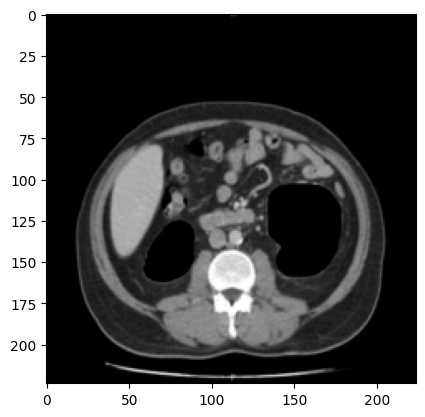

In [ ]:
plt.imshow(PILimage(datasets['test'][80][0]))

In [ ]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], shuffle=True, batch_size=32)
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], shuffle=False, batch_size=32)

In [ ]:
# noisy_dataloader = torch.utils.data.DataLoader(noisy_dataset, shuffle=False, batch_size=32)

# Train

In [ ]:
def one_epoch(model, loader, criterion, optimizer, scheduler, device, phase):

  if phase == 'train':
    model.train() # Set model to training mode
  else:
    model.eval()

  running_loss = 0.0
  running_accuracy = 0.0
  running_precision = 0.0
  running_recall = 0.0
  running_f1_score = 0.0

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    with torch.set_grad_enabled(phase == 'train'):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

    # statistics
    running_loss += loss.item()
    running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())
    running_precision += sklearn.metrics.precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_recall += sklearn.metrics.recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)
    running_f1_score += sklearn.metrics.f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=0)

    if phase == 'train' and scheduler:
        scheduler.step()

  loss = running_loss / len(loader)
  accuracy = running_accuracy / len(loader)
  precision = running_precision / len(loader)
  recall = running_recall / len(loader)
  f1_score = running_f1_score / len(loader)

  return loss, accuracy, precision, recall, f1_score

In [ ]:
def train(model, loaders, criterion, optimizer, num_epochs, device, scheduler=None):

  best_val_loss = float('inf')
  best_val_acc = 0
  # best_model = None

  accuracy_dic, loss_dic = {}, {}
  loss_dic['train'], loss_dic['validation'] = [], []
  accuracy_dic['train'], accuracy_dic['validation'] = [], []

  for epoch in range(num_epochs):
      train_loss, train_acc, train_precision, train_recall, train_f1 = one_epoch(model, loaders['train'], criterion, optimizer, scheduler, device, phase='train' )
      # val_loss, val_acc, val_precision, val_recall, val_f1 = one_epoch(model, loaders['validation'], criterion, optimizer, scheduler, device, phase='validation')

      loss_dic['train'].append(train_loss)
      # loss_dic['validation'].append(val_loss)
      accuracy_dic['train'].append(train_acc)
      # accuracy_dic['validation'].append(val_acc)

      # if val_loss < best_val_loss:
      #   best_val_acc = val_acc
      #   best_val_loss = val_loss
      #   # best_model = model.state_dict()
      #   torch.save(model.state_dict(), model_path)


      print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Train Precision {train_precision:.4f} - '
            f'Train Recall {train_recall:.4f} - '
            f'Train F1-score {train_f1:.4f} ')
            # f'Validation Loss: {val_loss:.4f} - '
            # f'Validation Accuracy {val_acc:.4f} - '
            # f'Validation Precision {val_precision:.4f} - '
            # f'Validation Recall {val_recall:.4f} - '
            # f'Validation F1-score {val_f1:.4f} ')

  return loss_dic, accuracy_dic

In [ ]:
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+metric)
  # plt.plot(e, data['valid'], label='validation '+metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

In [ ]:
# model = torchvision.models.alexnet(pretrained=True)
# input_features = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(in_features=input_features, out_features=len(classes), bias=True)

model = torchvision.models.resnet18(pretrained=True)
input_features = model.fc.in_features
model.fc = nn.Linear(in_features=input_features, out_features=len(classes), bias=True)

model.to(device)

In [ ]:
classes

['AML', 'Chromophobe RCC', 'Clear Cell RCC', 'Simple Cyst']

In [ ]:
class_weights=compute_class_weight('balanced', classes=classes, y=train_data['class_name'])
class_weights = torch.FloatTensor(class_weights).to(device)
class_weights

tensor([1.0000, 1.0208, 1.0000, 0.9800], device='cuda:0')

In [ ]:
model_path = '/content'

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

num_epochs = 20

In [ ]:
loss_dic, accuracy_dic = train(model, dataloaders, criterion, optimizer, num_epochs, device, scheduler=None)

Epoch [1/20] - Train Loss: 1.0099 - Train Accuracy: 0.5938 - Train Precision 0.6260 - Train Recall 0.5938 - Train F1-score 0.5753 
Epoch [2/20] - Train Loss: 0.4063 - Train Accuracy: 0.9107 - Train Precision 0.9266 - Train Recall 0.9107 - Train F1-score 0.9111 
Epoch [3/20] - Train Loss: 0.2394 - Train Accuracy: 0.9420 - Train Precision 0.9499 - Train Recall 0.9420 - Train F1-score 0.9421 
Epoch [4/20] - Train Loss: 0.1807 - Train Accuracy: 0.9375 - Train Precision 0.9583 - Train Recall 0.9375 - Train F1-score 0.9377 
Epoch [5/20] - Train Loss: 0.0927 - Train Accuracy: 0.9866 - Train Precision 0.9881 - Train Recall 0.9866 - Train F1-score 0.9866 
Epoch [6/20] - Train Loss: 0.0666 - Train Accuracy: 0.9911 - Train Precision 0.9921 - Train Recall 0.9911 - Train F1-score 0.9911 
Epoch [7/20] - Train Loss: 0.0609 - Train Accuracy: 0.9911 - Train Precision 0.9922 - Train Recall 0.9911 - Train F1-score 0.9911 
Epoch [8/20] - Train Loss: 0.0483 - Train Accuracy: 1.0000 - Train Precision 1.0000

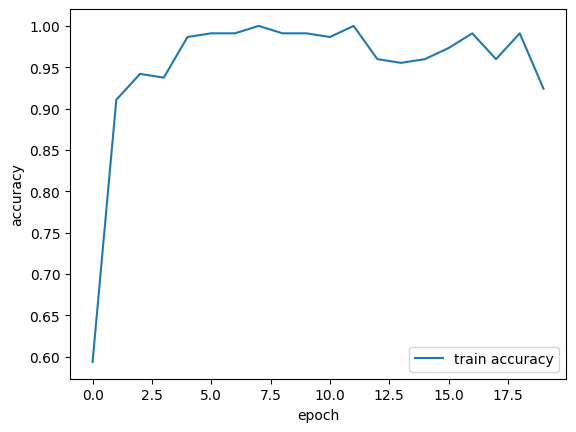

In [ ]:
show_plots(num_epochs, accuracy_dic, 'accuracy')

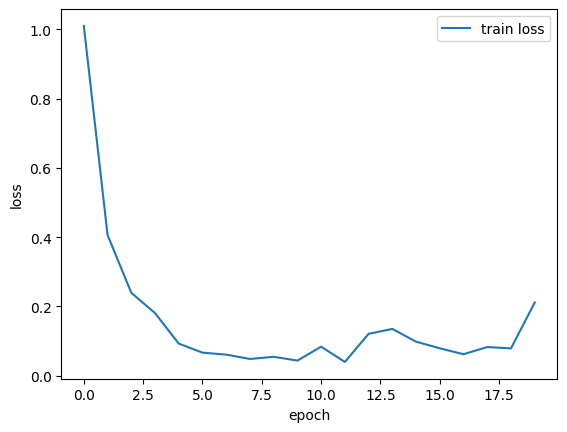

In [ ]:
show_plots(num_epochs, loss_dic, 'loss')

# Evaluate

In [ ]:
def evaluate(model, loader, criterion, optimizer, device, phase, scheduler=None):

  loss, accuracy, precision, recall, f1_score = one_epoch(model, loader, criterion, optimizer, scheduler, device, 'test')

  print(f'{phase} Loss: {loss:.4f} - '
        f'{phase} Accuracy {accuracy:.2f} - '
        f'{phase} Precision: {precision:.2f} - '
        f'{phase} Recall {recall:.2f} - '
        f'{phase} F1: {f1_score:.2f}')


In [ ]:
def plot_confusionmatrix(y_pred, y_true, classes):
  print('Confusion matrix')
  cf = sklearn.metrics.confusion_matrix(y_pred, y_true, labels=np.arange(len(classes)))
  sns.heatmap(cf,annot=True,yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
  plt.tight_layout()
  plt.show()

In [ ]:
def report(model, loader, device, classes):

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  y_pred = []
  y_true = []

  # Iterate over data.
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu())
      y_true.extend(labels)

  plot_confusionmatrix(y_pred, y_true, classes)

In [ ]:
# model.load_state_dict(torch.load(model_path))

In [ ]:
evaluate(model, dataloaders['train'], criterion, optimizer, device, 'train')

train Loss: 0.0192 - train Accuracy 1.00 - train Precision: 1.00 - train Recall 1.00 - train F1: 1.00


Confusion matrix


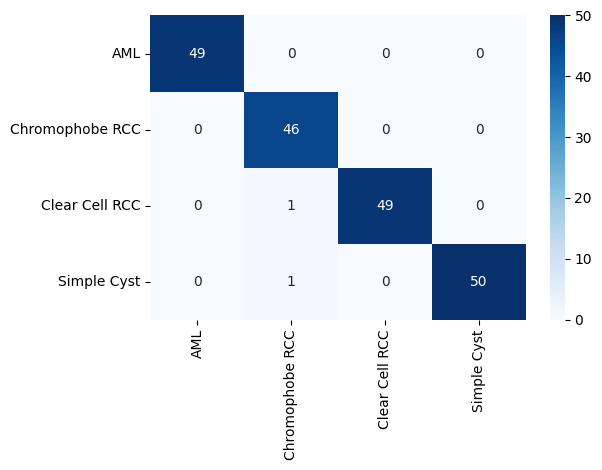

In [ ]:
report(model, dataloaders['train'], device, classes)

In [ ]:
evaluate(model, dataloaders['test'], criterion, optimizer, device, 'test')

test Loss: 0.0189 - test Accuracy 0.99 - test Precision: 0.99 - test Recall 0.99 - test F1: 0.99


Confusion matrix


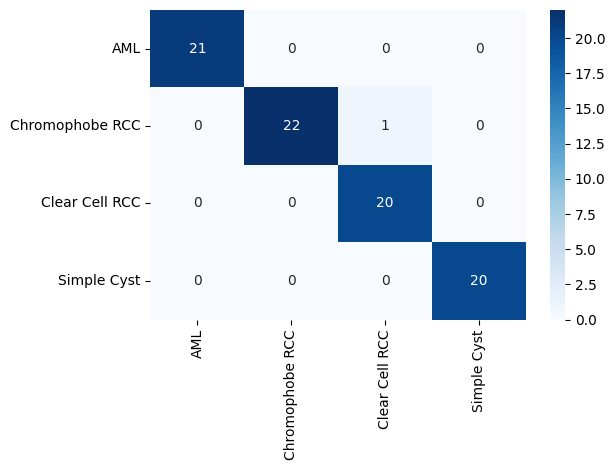

In [ ]:
report(model, dataloaders['test'], device, classes)

#### noisy

In [ ]:
# plt.imshow(PILimage(noisy_dataset[5][0]))

In [ ]:
# evaluate(model, noisy_dataloader, criterion, optimizer, device, 'noisy')

noisy Loss: 2.3522 - noisy Acuracy 0.39 - noisy Precision: 0.27 - noisy Recall 0.39 - noisy F1: 0.32


Confusion matrix


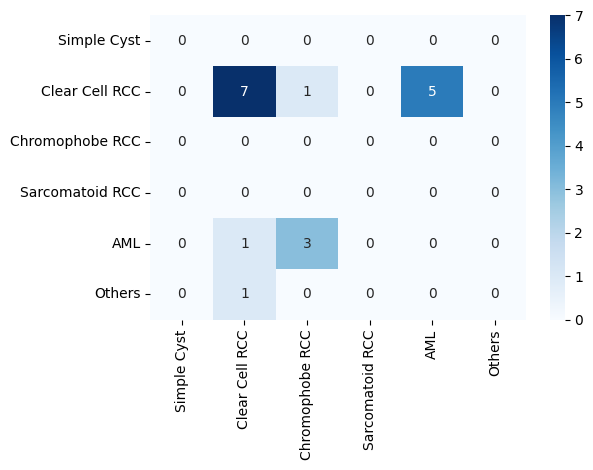

In [ ]:
# report(model, noisy_dataloader, device, classes)

# Interpretability (GradCam)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import to_pil_image


def plot_GradCam(model, image):
    target_layers = [model.layer4[-1]]
    input_tensor = torch.unsqueeze(image, dim=0)
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(1)] # one class

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    img = np.array(to_pil_image(image))/255

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    return grayscale_cam, visualization


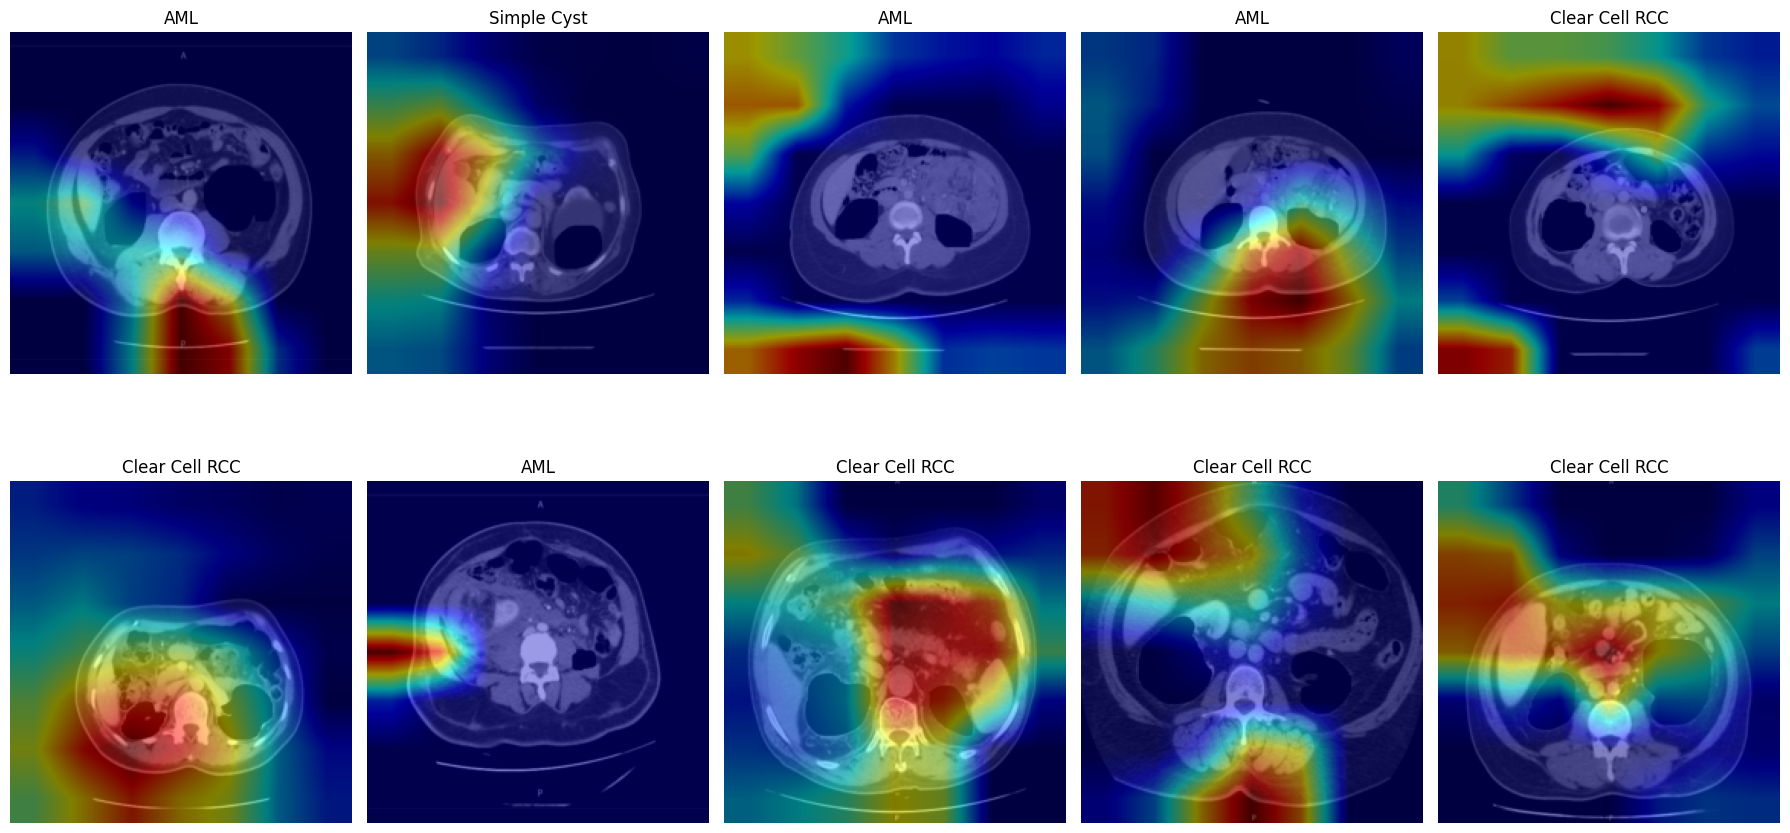

In [ ]:
k=10
indicies = np.random.choice(len(datasets['test']), k)
np.random.shuffle(indicies)

fig,axs = plt.subplots(k//5,5, figsize=(18,10))
idx=0

for i, ax in enumerate(axs.flatten()):
  image, label = datasets['test'][indicies[idx]]
  grayscale_cam, vis = plot_GradCam(model, image)
  ax.imshow(vis)
  ax.axis("off")
  ax.title.set_text(classes[label])
  idx += 1

plt.tight_layout()
plt.show()